In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [22]:
results_path = '../src_results/5.csv'
if not os.path.exists(results_path):
    print(f"Error: File {results_path} not found. Run the C++ benchmark first!")
else:
    print("Data file found. Loading...")

Data file found. Loading...


In [23]:
df = pd.read_csv(results_path)

# Базовое время (Static, 1 поток)
base_times = df[(df['Threads'] == 1) & (df['Schedule'] == 'Static')][['MatrixType', 'Size', 'Time']]
base_times = base_times.rename(columns={'Time': 'BaseTime'})

df = pd.merge(df, base_times, on=['MatrixType', 'Size'], how='left')

df['Time_ms'] = df['Time'] * 1000
df['Speedup'] = df['BaseTime'] / df['Time']
df['Efficiency'] = df['Speedup'] / df['Threads']

matrix_types = ['Triangular', 'Band']
metrics = [
    ('Time_ms', 'Time (ms)'),
    ('Speedup', 'Speedup'),
    ('Efficiency', 'Efficiency')
]

max_sizes = {m: df[df['MatrixType'] == m]['Size'].max() for m in matrix_types}

Generating Schedule Comparison (Max Size)...


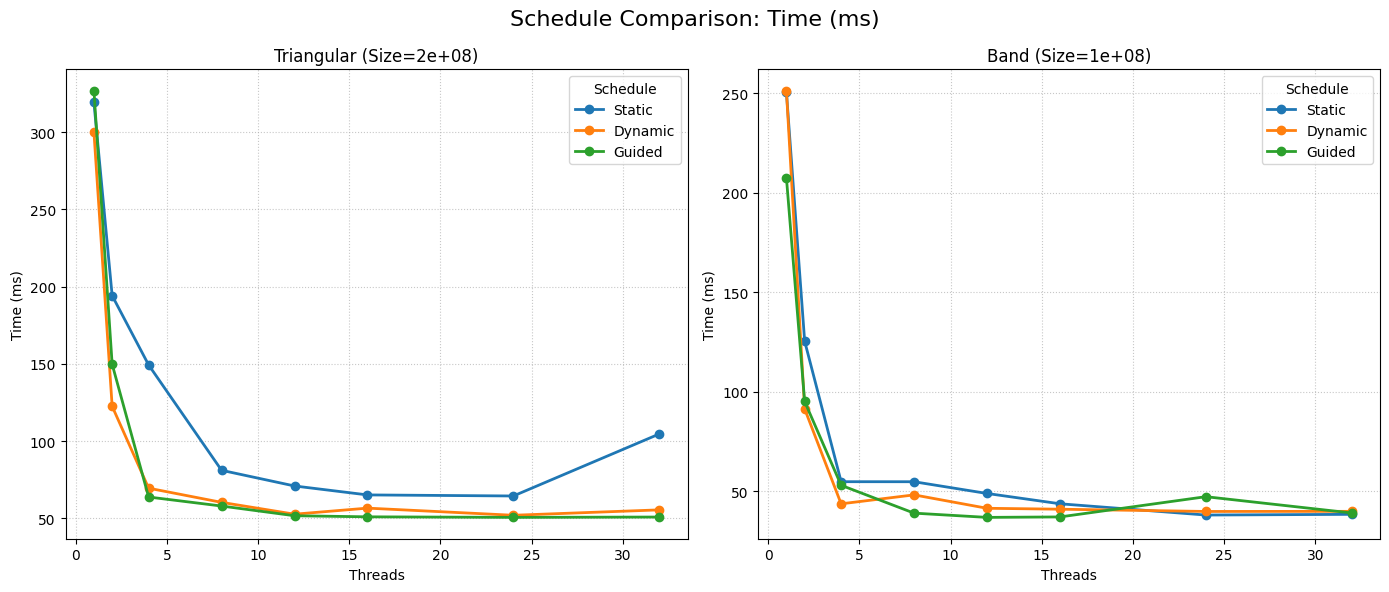

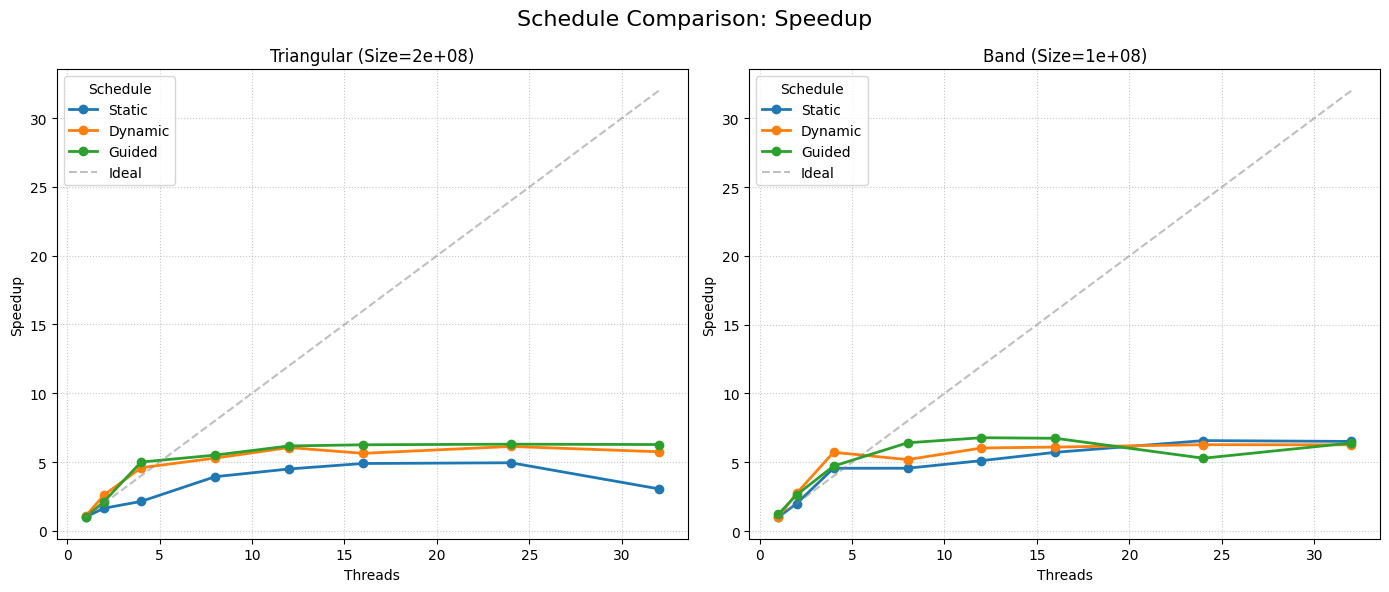

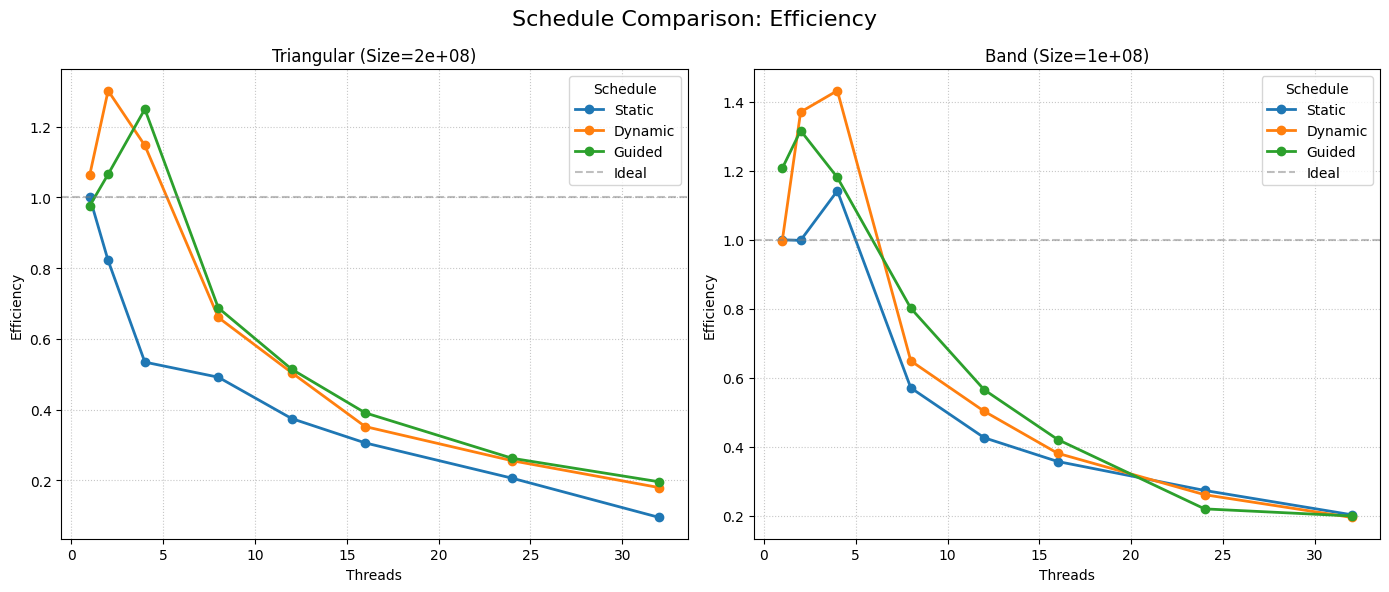

Generating Size Comparison per Schedule...


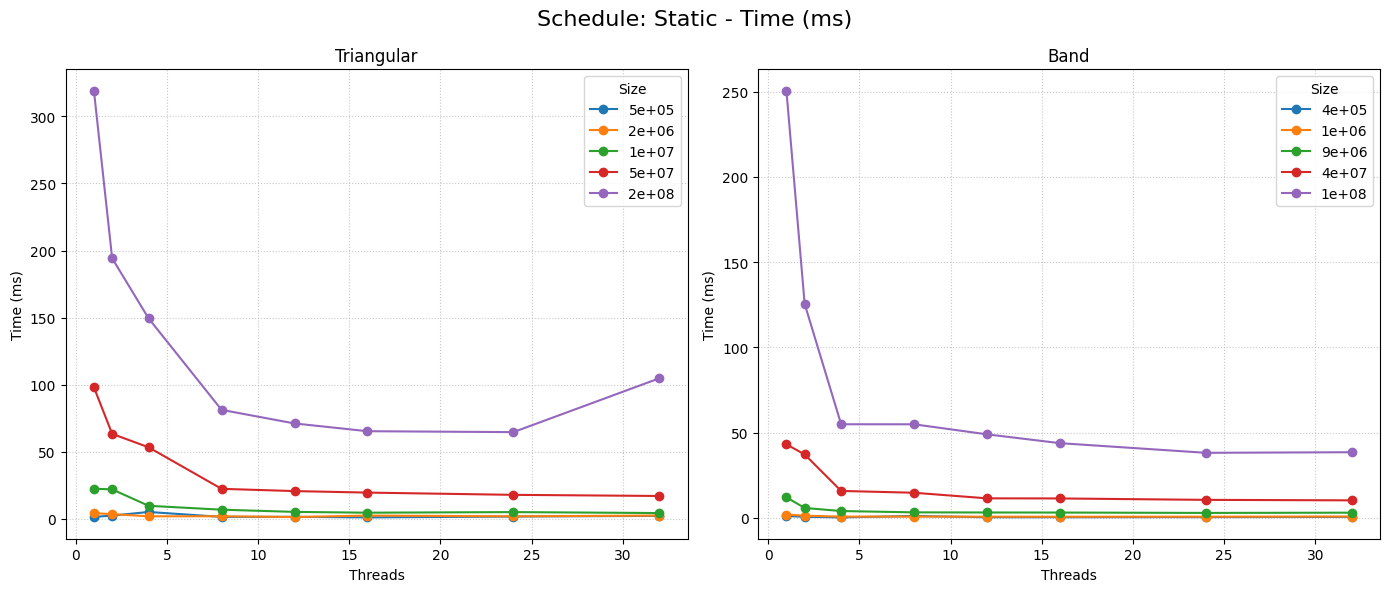

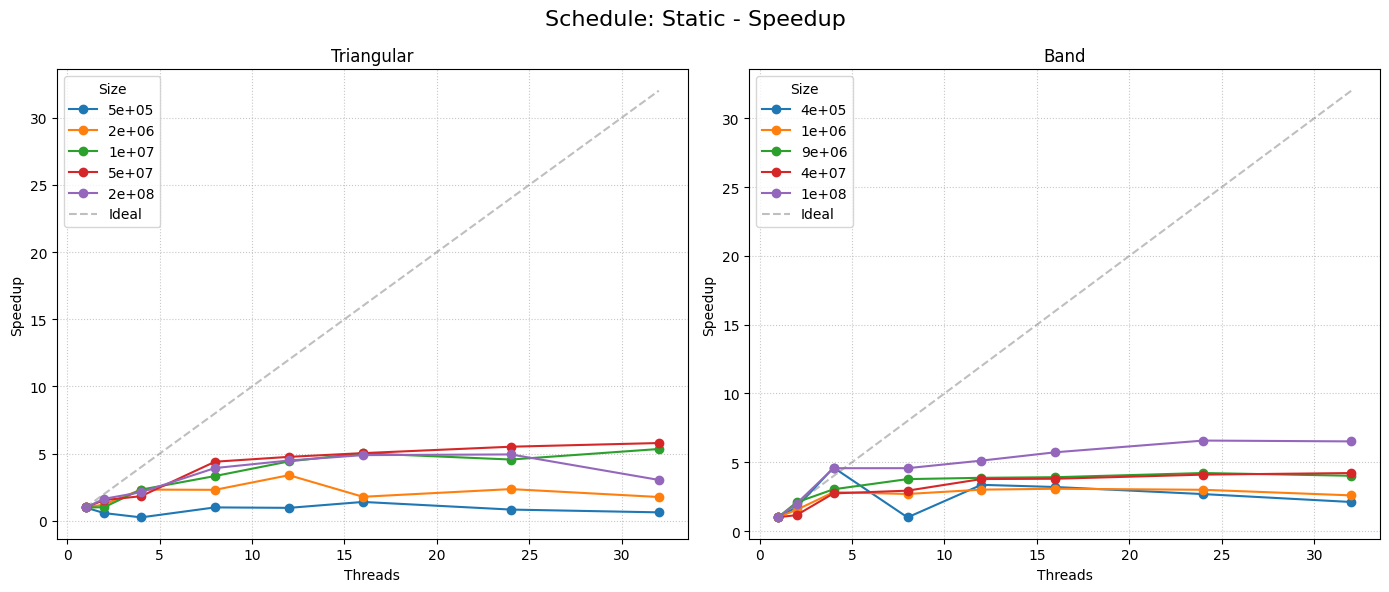

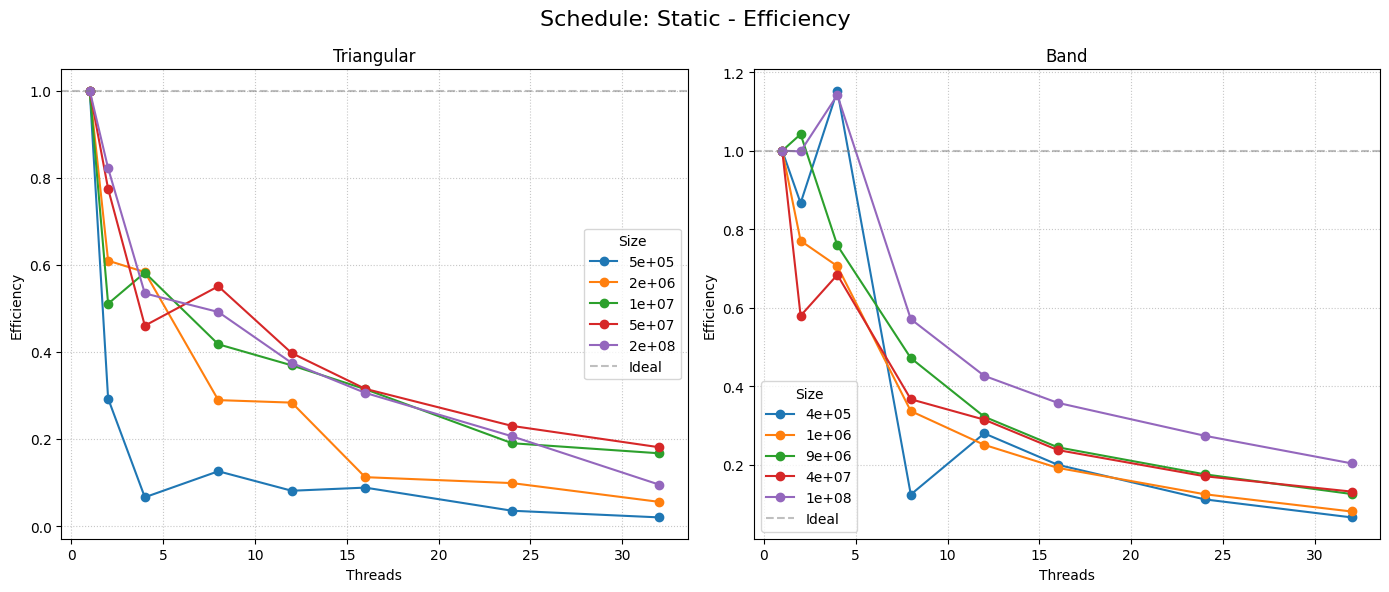

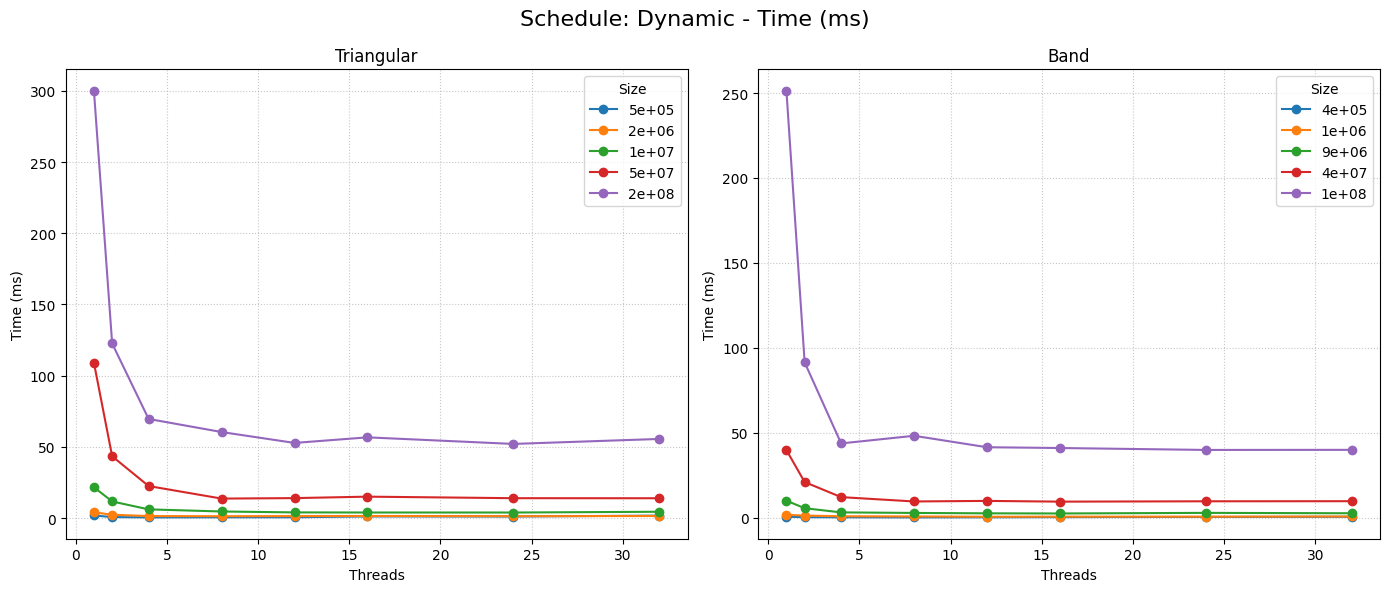

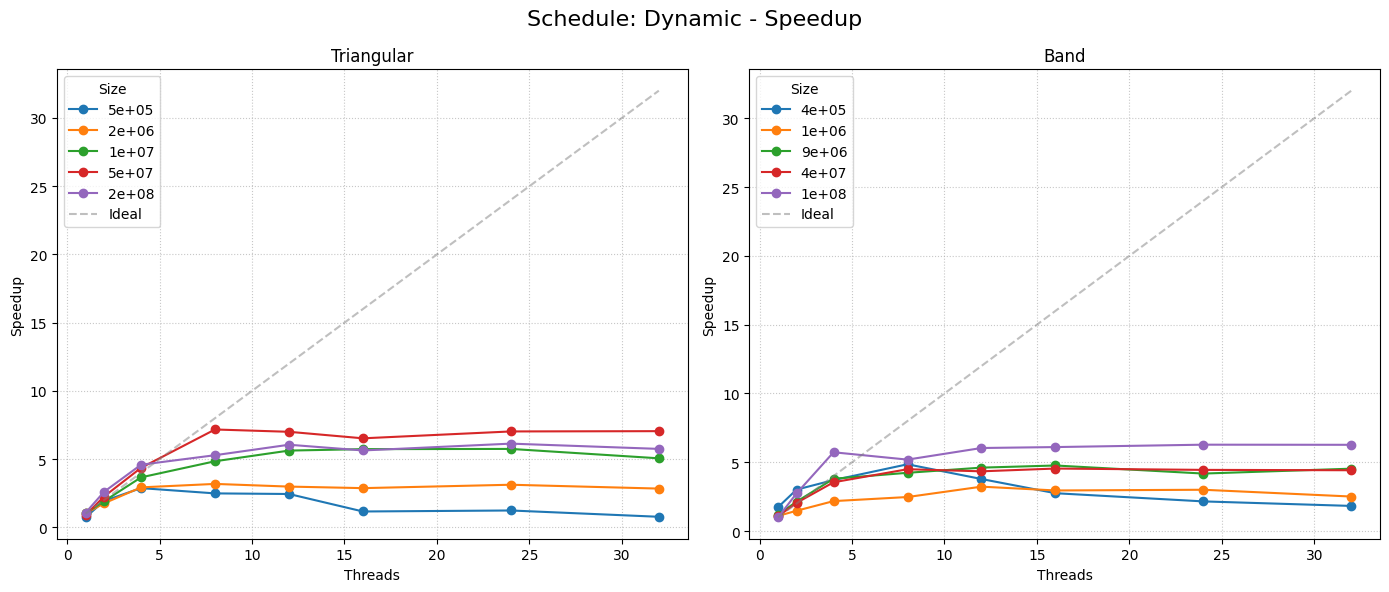

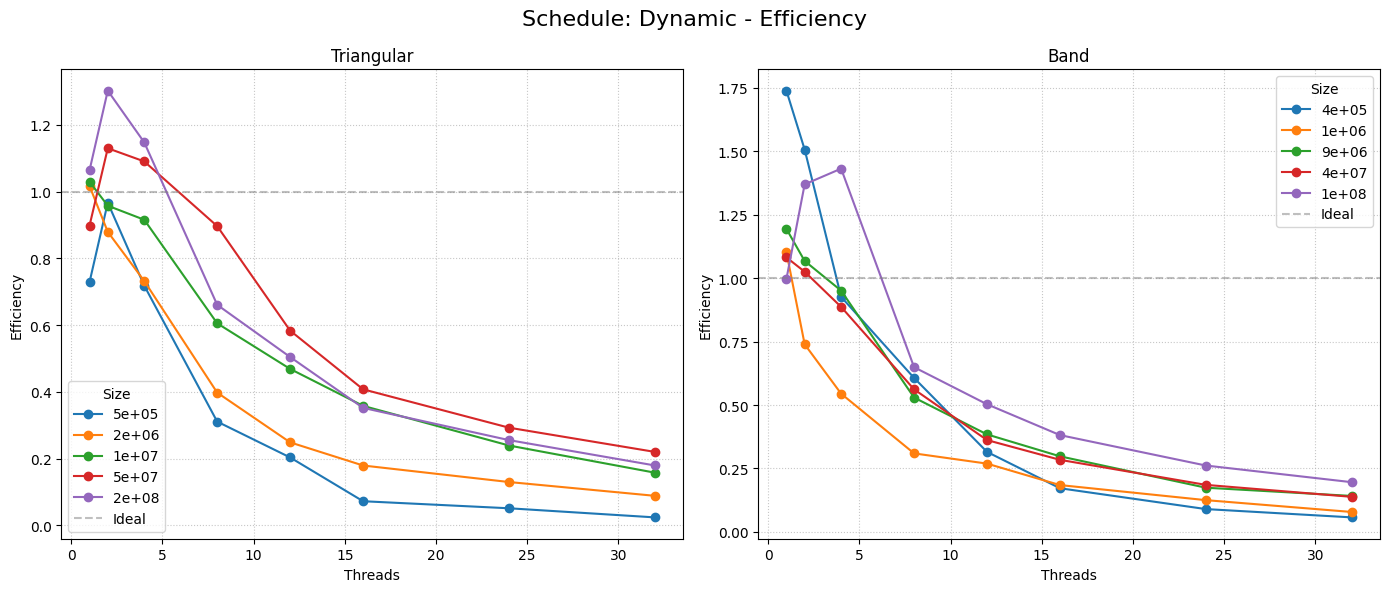

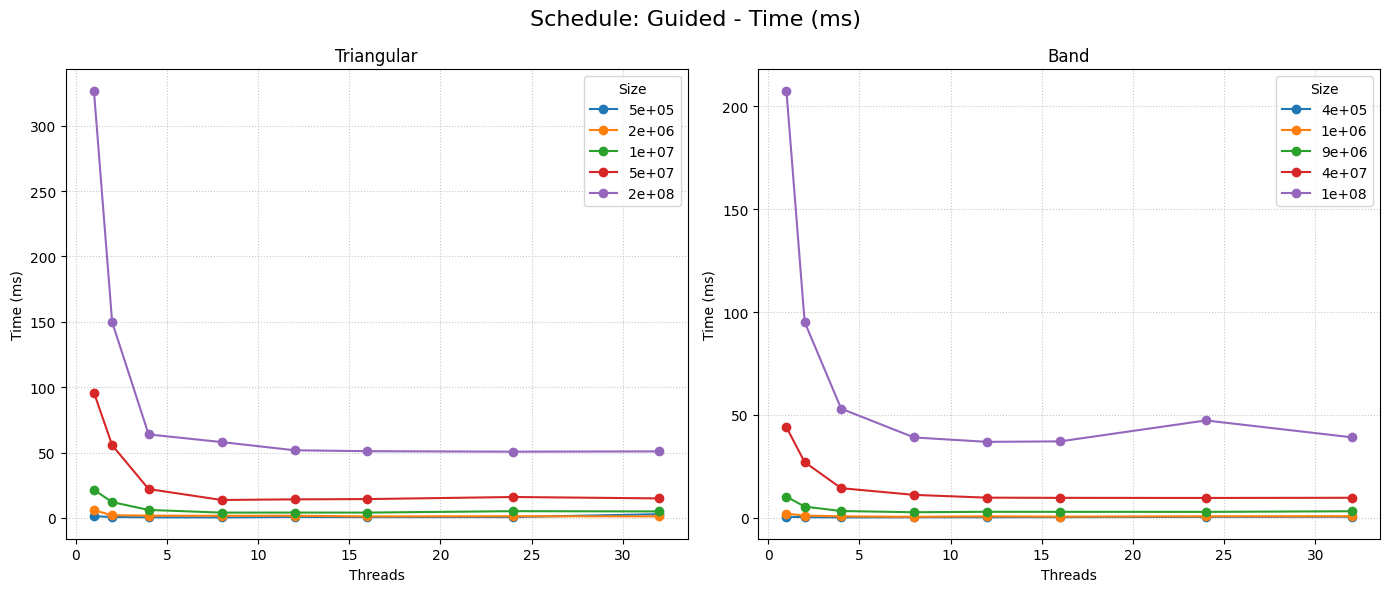

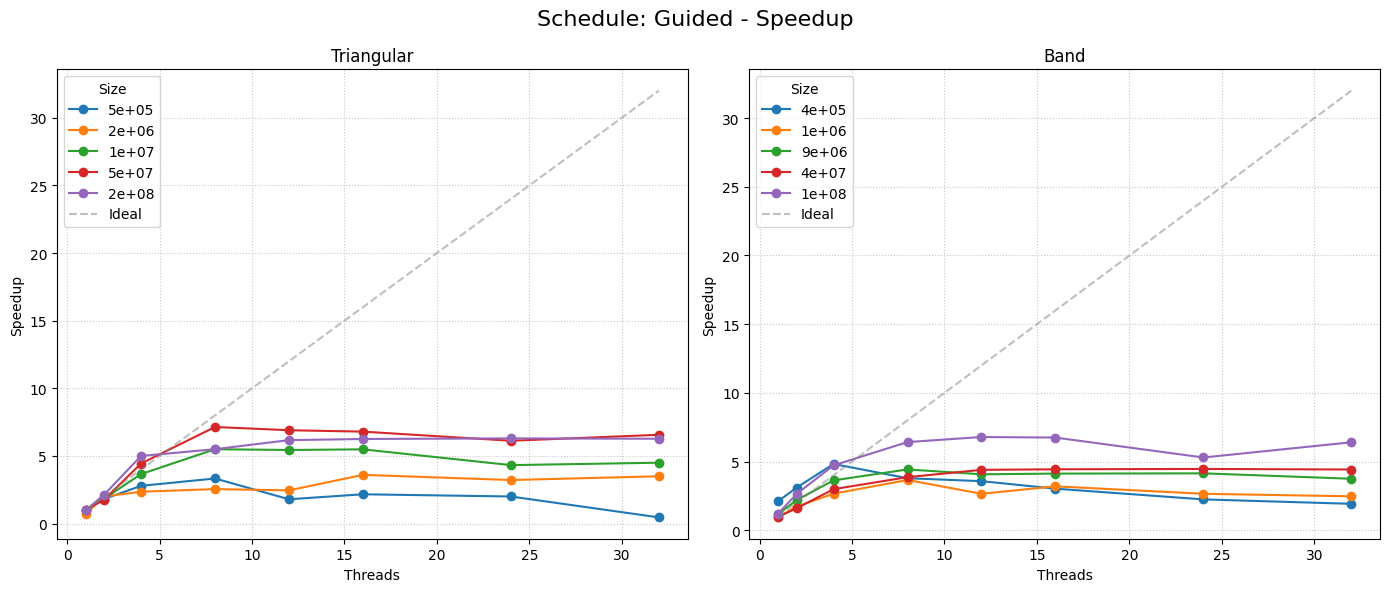

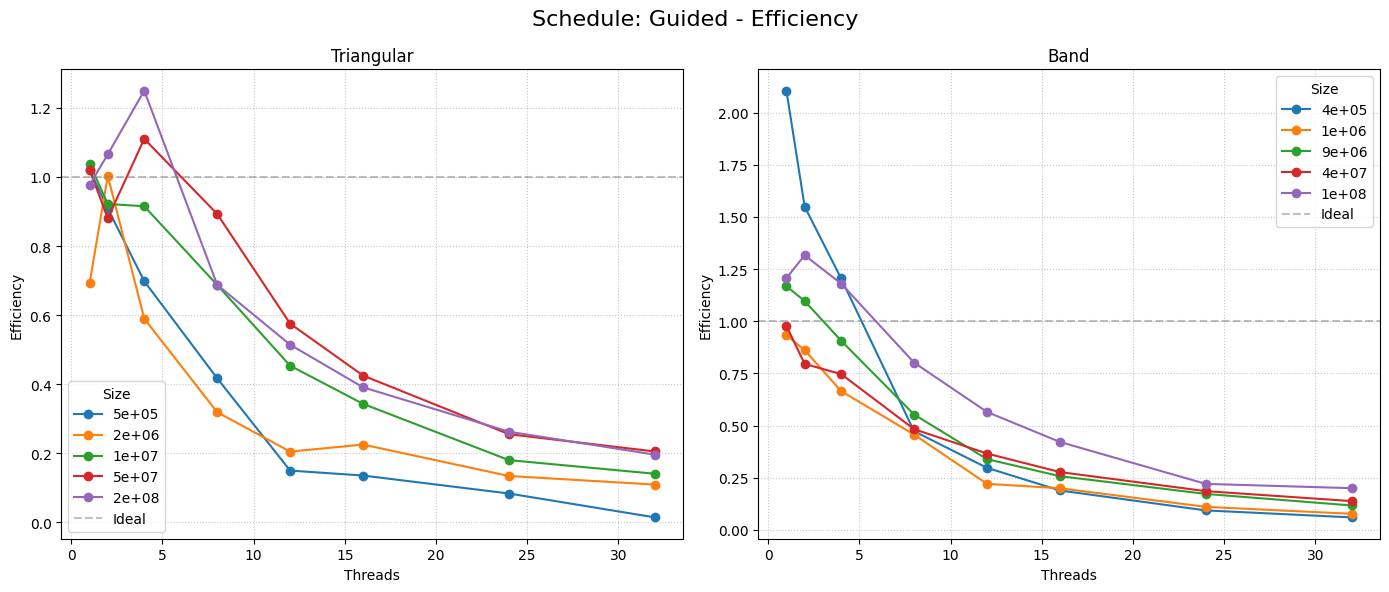

All plots saved.


In [ ]:
plt.style.use('default')
print("Generating Schedule Comparison (Max Size)...")

for metric, ylabel in metrics:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for ax, m_type in zip(axes, matrix_types):
        subset = df[(df['MatrixType'] == m_type) & (df['Size'] == max_sizes[m_type])]
        schedules = subset['Schedule'].unique()

        for sched in schedules:
            data = subset[subset['Schedule'] == sched].sort_values('Threads')
            ax.plot(data['Threads'], data[metric], marker='o', linewidth=2, label=sched)
        
        if metric == 'Speedup':
            max_th = df['Threads'].max()
            ax.plot([1, max_th], [1, max_th], '--', color='gray', alpha=0.5, label='Ideal')
        elif metric == 'Efficiency':
            ax.axhline(1.0, linestyle='--', color='gray', alpha=0.5, label='Ideal')

        ax.set_title(f'{m_type} (Size={max_sizes[m_type]:.0e})')
        ax.set_xlabel('Threads')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(title='Schedule')

    fig.suptitle(f'Schedule Comparison: {ylabel}', fontsize=16)
    plt.tight_layout()
    plt.show()


print("Generating Size Comparison per Schedule...")

all_schedules = df['Schedule'].unique()

for sched in all_schedules:
    for metric, ylabel in metrics:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        for ax, m_type in zip(axes, matrix_types):
            subset = df[(df['MatrixType'] == m_type) & (df['Schedule'] == sched)]
            sizes = sorted(subset['Size'].unique())

            for s in sizes:
                data = subset[subset['Size'] == s].sort_values('Threads')
                ax.plot(data['Threads'], data[metric], marker='o', label=f'{s:.0e}')
            
            if metric == 'Speedup':
                max_th = df['Threads'].max()
                ax.plot([1, max_th], [1, max_th], '--', color='gray', alpha=0.5, label='Ideal')
            elif metric == 'Efficiency':
                ax.axhline(1.0, linestyle='--', color='gray', alpha=0.5, label='Ideal')

            ax.set_title(f'{m_type}')
            ax.set_xlabel('Threads')
            ax.set_ylabel(ylabel)
            ax.grid(True, linestyle=':', alpha=0.7)
            ax.legend(title='Size')

        fig.suptitle(f'Schedule: {sched} - {ylabel}', fontsize=16)
        plt.tight_layout()
        plt.show()